In [1]:
import os
from typing import Dict
import requests
from tavily import TavilyClient
from langchain_core.tools import tool
from langchain_core.messages import (
    SystemMessage,
    AIMessage,
    HumanMessage, 
    ToolMessage,
)
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState, add_messages
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
@tool
def random_got_quote_tool()->Dict:
    """
    Return a random Game of Thrones quote and the character who said it
    """
    response = requests.get("https://api.gameofthronesquotes.xyz/v1/random")
    return response.json()

In [4]:
random_got_quote_tool.invoke({})

{'sentence': 'I have a tender spot in my heart for cripples, bastards and broken things.',
 'character': {'name': 'Tyrion Lannister',
  'slug': 'tyrion',
  'house': {'name': 'House Lannister of Casterly Rock', 'slug': 'lannister'}}}

In [ ]:
@tool
def web_search(question:str)->Dict:
    """
    Return top search results for a given search query
    """
    tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
    response = tavily_client.search(question)
    return response

In [6]:
web_search.invoke(
    {
        "question": "Who performs Tyrion Lannister in Game of Thrones?"
    }
)

{'query': 'Who performs Tyrion Lannister in Game of Thrones?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Tyrion Lannister played by Peter Dinklage on Game of Thrones - Official ...',
   'url': 'https://www.hbo.com/game-of-thrones/cast-and-crew/tyrion-lannister',
   'content': 'Tyrion Lannister Played by Peter Dinklage Called "The Imp," because of his small stature, he is the youngest son of Tywin Lannister, the richest lord in the Seven Kingdoms and younger brother to Queen Cersei and Ser Jaime Lannister.',
   'score': 0.8536326,
   'raw_content': None},
  {'title': 'Biography, Movies, Game of Thrones, & Facts - Britannica',
   'url': 'https://www.britannica.com/biography/Peter-Dinklage',
   'content': 'Peter Dinklage | Biography, Movies, Game of Thrones, & Facts | Britannica Ask the Chatbot Games & Quizzes History & Society Science & Tech Biographies Animals & Nature Geography & Travel Arts & Culture ProCon Money Videos Peter Dinklage (born 

In [7]:
tools = [random_got_quote_tool, web_search]

In [8]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [9]:
llm_with_tools = llm.bind_tools(tools)

In [10]:
def agent(state: MessagesState):
    ai_message = llm_with_tools.invoke(state["messages"])
    return {"messages": ai_message}

In [11]:
def router(state: MessagesState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"

    return END

In [12]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", agent)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    source="agent", 
    path=router, 
    path_map=["tools", END]
)

workflow.add_edge("tools", "agent")


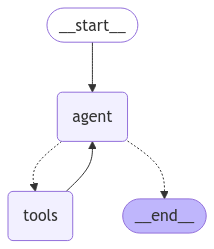

In [13]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [14]:
messages = [
    SystemMessage(
        "You are a Web Researcher focused on Game of Thrones. "
        "If user asks you a random quote about GoT. You will not only " 
        "provide it, but also search the web to find the actor or actress "
        "who perform the character who said that."
        "So, your output should be: Quote, Character and Performer."
    ),
    HumanMessage("Give me a radom GoT quote")
]

In [15]:
graph.invoke(
    input={
        "messages": messages
    }
)

{'messages': [SystemMessage(content='You are a Web Researcher focused on Game of Thrones. If user asks you a random quote about GoT. You will not only provide it, but also search the web to find the actor or actress who perform the character who said that.So, your output should be: Quote, Character and Performer.', additional_kwargs={}, response_metadata={}, id='5b575166-4d01-4eff-8a28-c9dd76b88a38'),
  HumanMessage(content='Give me a radom GoT quote', additional_kwargs={}, response_metadata={}, id='f149bc5d-3d47-424d-9bfe-926c6c700456'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4MEsVvxW4DVY6J8I4BWIIrCK', 'function': {'arguments': '{}', 'name': 'random_got_quote_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 141, 'total_tokens': 155, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_t